# Demonstrating BP decoding of CSS-type Quantum LDPC Codes.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time # for throughput measurements
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # INFO and WARNING messages are not printed
import tensorflow as tf

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

# uninstall sionna first
import sys
from pathlib import Path

sys.path.append(str(Path('..')))

from sionna.fec.ldpc import QLDPCBPDecoder 
from sionna.fec.ldpc import *
# from sionna.fec.linear import OSDecoder
from sionna.utils import BinarySource 
from sionna.utils.metrics import count_block_errors
from sionna.channel import Pauli
from sionna.utils.plotting import PlotBER
from sionna.fec.utils import int_mod_2

Number of GPUs available : 1
Only GPU number 0 used.


## Create surface, toric, steane code.
BP decoder alone does not perform well on those code.

In [2]:
Surface_n1201_k1_d25 = create_surface_codes(25)
Rotated_Surface_n121_k1_d11 = create_rotated_surface_codes(11)
Toric_n100_k2_d10 = create_checkerboard_toric_codes(10)
Steane_n7_k1_d3 = css_code(hamming_code(3), hamming_code(3), name="Steane_n7_k1_d3")
code = Steane_n7_k1_d3
print(f"Constructed {code.name} code, blocklength N={code.N}, number of logical bits K={code.K}")
print(f"X parity check matrix Hx={code.hx}.\nZ parity check matrix Hz={code.hz}")
print(f"Logical X operator Lx={code.lx}. Logical Z operator Lz={code.lz}")

Constructed Steane_n7_k1_d3 code, blocklength N=7, number of logical bits K=1
X parity check matrix Hx=[[0 0 0 1 1 1 1]
 [0 1 1 0 0 1 1]
 [1 0 1 0 1 0 1]].
Z parity check matrix Hz=[[0 0 0 1 1 1 1]
 [0 1 1 0 0 1 1]
 [1 0 1 0 1 0 1]]
Logical X operator Lx=[[1 1 1 0 0 0 0]]. Logical Z operator Lz=[[1 1 1 0 0 0 0]]


## Create CSS-type QLDPC codes from [1].
[1] P. Panteleev and G. Kalachev, “Degenerate quantum LDPC codes with good ﬁnite length performance,” Quantum, vol. 5, 2021.

[2] Quaternary Neural Belief Propagation Decoding of Quantum LDPC Codes with Overcomplete Check Matrices


In [10]:
# Generalized Bicycle Codes
GB_n254_k28 = create_generalized_bicycle_codes(127, [0,15,20,28,66], [0,58,59,100,121]) # 14 <= d <= 20
GB_n126_k28_d8 = create_generalized_bicycle_codes(63, [0,1,14,16,22], [0,3,13,20,42], name="GB_n126_k28_d8")

GB_n48_k6_d8 = create_generalized_bicycle_codes(24, [0,2,8,15], [0,2,12,17], name="GB_n48_k6_d8")
# create the code using the overcomplete check matrices in [2]
GB_n48_pcm = readAlist('../sionna/fec/ldpc/codes_q/GB_48_6_H_2000.alist')
GB_n48_k6_d8_oc = css_code(hx=GB_n48_pcm[:1000], hz=GB_n48_pcm[1000:], name=None, name_prefix="GB")
GB_n48_k6_d8_oc.name += "_oc"

GB_n46_k2_d9 = create_generalized_bicycle_codes(23, [0,5,8,12], [0,1,5,7], name="GB_n46_k2_d9")
# create the code using the overcomplete check matrices in [2]
GB_n46_pcm = readAlist('../sionna/fec/ldpc/codes_q/GB_46_2_H_800.alist')
GB_n46_k2_d9_oc = css_code(hx=GB_n46_pcm[:400], hz=GB_n46_pcm[400:], name=None, name_prefix="GB")
GB_n46_k2_d9_oc.name += "_oc"

GB_n180_n10 = create_generalized_bicycle_codes(90, [0,28,80,89], [0,2,21,25]) # 15 <= d <= 18
GB_n900_k50_d15 = create_generalized_bicycle_codes(450, [0,97,372,425], [0,50,265,390], name="GB_n900_k50_d15")

# Hypergraph Product Codes
# HP_n7935_n578_H = create_circulant_matrix(63, [0,3,34,41,57]) 
# HP_n7935_n578_d16 = hypergraph_product(HP_n7935_n578_H, HP_n7935_n578_H, name="HP_n7935_n578_d16") # takes 40 seconds
HP_n1922_k50_H = create_circulant_matrix(31, [0,2,5])
HP_n1922_n50_d16 = hypergraph_product(HP_n1922_k50_H, HP_n1922_k50_H, name="HP_n1922_k50_d16")

# Generalized Hypergraph Product Codes
GHP_n882_k24 = create_QC_GHP_codes(63, create_cyclic_permuting_matrix(7, [27,54,0]), [0,1,6]) # 18 <= d <= 24
GHP_n882_k48_d16 = create_QC_GHP_codes(63, create_cyclic_permuting_matrix(7, [27,0,27,18,0]), [0,1,6], name="GHP_n882_k48_d16")
GHP_n1270_k28 = create_QC_GHP_codes(127, np.array([[0,-1,51,52,-1],[-1,0,-1,111,20],[0,-1,98,-1,122],[0,80,-1,119,-1],[-1,0,5,-1,106]]), [0,1,7], name="GHP_n1270_k28") # 16 <= d <= 46


# Binary BP decoding for Binary Symmetric Channel (BSC).

In [13]:
code = GHP_n882_k24
decoder = LDPCBPDecoder(code.hx, is_syndrome=True, num_iter=64) # binary syndrome BP decoder
# noise added by BSC channel
model = BP_BSC_Model(pcm=code.hx, decoder=decoder, logical_pcm=code.hz_perp, p0=0.2) # p0 is used to initialize BP
# If p0 is not specified (default set to None), then the actual p value employed for noise generation will be used for BP initialization.
p_range = np.arange(0.01,0.101,0.01)[::-1] * 2/3 

ber_plot = PlotBER("Performance of the [[882,24]] code on BSC channel under binary decoding")

ber_plot.simulate(model, 
                  ebno_dbs=p_range, # physical error rates to simulate
                  legend=f"{code.name}, factor={1.0}, iter={64}, p0=0.2", # legend string for plotting
                  max_mc_iter=1000, # run 1000 Monte Carlo runs per physical error rate point
                  num_target_block_errors=100, # continue with next physical error rate point after 1000 block errors
                  batch_size=10000, # batch-size per Monte Carlo run
                  soft_estimates=False, # the model returns hard-estimates
                  early_stop=True, # stop simulation if no error has been detected at current physical error rate
                  show_fig=False, # do not show the figure after all results are simulated
                  add_bler=True, # we are interested in block error rate
                  qldpc=True, # show flagged error rate, instead of showing bit error rate
                  forward_keyboard_interrupt=True); # should be True in a loop

        p |    Flagged |       BLER | flag errors | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    0.067 | 8.6080e-01 | 8.6080e-01 |        8608 |         8608 |       10000 |         0.9 |reached target block errors
     0.06 | 6.2530e-01 | 6.2530e-01 |        6253 |         6253 |       10000 |         0.1 |reached target block errors
    0.053 | 3.0550e-01 | 3.0550e-01 |        3055 |         3055 |       10000 |         0.1 |reached target block errors
    0.047 | 7.9800e-02 | 7.9800e-02 |         798 |          798 |       10000 |         0.1 |reached target block errors
     0.04 | 1.0100e-02 | 1.0100e-02 |         202 |          202 |       20000 |         0.2 |reached target block errors
    0.033 | 6.4375e-04 | 6.4375e-04 |         103 |          103 |      160000 |         2.0 |reached target block errors
    0.027 | 2.7297e-04 | 2.

# Quaternary BP decoding for Depolarizing Channel.

In [5]:
code = create_rotated_surface_codes(3)

num_iter = tf.constant(60)
factor = tf.constant(0.8)
p0 = tf.constant(0.05)
# quaternary syndrome BP decoder
decoder = QLDPCBPDecoder(code=code, num_iter=num_iter, normalization_factor=factor, cn_type="boxplus-phi", trainable=False, stage_one=True)
# noise added by depolarizing channel
model_eval = Sandwich_BP_GNN_Evaluation_Model(code, [decoder], [], num_layers=1, p0=p0) # p0 is used to initialize BP
# If p0 is not specified (default set to None), then the actual p value employed for noise generation will be used for BP initialization.
p_range = np.arange(0.01, 0.101, 0.01)[::-1] 

ber_plot = PlotBER("Performance of LDPC codes on depolarizing channel under quaternary decoding") # overwrite the previous one
ber_plot.simulate(model_eval,
              ebno_dbs=p_range,
              batch_size=10000,
              num_target_block_errors=100, 
              legend=f"{code.name}, factor={factor.numpy():.2f}, iter={num_iter}, p0={0.05}",
              soft_estimates=True,
              max_mc_iter=30000, 
              early_stop=True, 
              add_bler=True, 
              show_fig=False, 
              qldpc=True,
              forward_keyboard_interrupt=False)

        p |    Flagged |       BLER | flag errors | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.1 | 2.7470e-01 | 3.0780e-01 |        2747 |         3078 |       10000 |         2.0 |reached target block errors
     0.09 | 2.5270e-01 | 2.7920e-01 |        2527 |         2792 |       10000 |         0.0 |reached target block errors
     0.08 | 2.2030e-01 | 2.4310e-01 |        2203 |         2431 |       10000 |         0.0 |reached target block errors
     0.07 | 1.9220e-01 | 2.1170e-01 |        1922 |         2117 |       10000 |         0.0 |reached target block errors
     0.06 | 1.6830e-01 | 1.8220e-01 |        1683 |         1822 |       10000 |         0.0 |reached target block errors
     0.05 | 1.3490e-01 | 1.4600e-01 |        1349 |         1460 |       10000 |         0.0 |reached target block errors
     0.04 | 1.0650e-01 | 1.

(<tf.Tensor: shape=(10,), dtype=float64, numpy=
 array([0.2747, 0.2527, 0.2203, 0.1922, 0.1683, 0.1349, 0.1065, 0.0812,
        0.0559, 0.0276])>,
 <tf.Tensor: shape=(10,), dtype=float64, numpy=
 array([0.3078, 0.2792, 0.2431, 0.2117, 0.1822, 0.146 , 0.1131, 0.0854,
        0.0573, 0.0279])>)

## Evaluate some of the quantum LDPC codes from [1].

In [6]:
# Create list of (model, p_range, parameters) triplets to be analyzed.
# This allows automated evaluation of the whole list later.
codes_under_test = []

def define_code(code, num_iter=32, factor=0.625, p0=None, p_range=np.arange(0.01,0.101,0.01)[::-1]):
    decoder = QLDPCBPDecoder(code=code, num_iter=num_iter, normalization_factor=factor, cn_type="boxplus-phi", trainable=False, stage_one=True)
    model = Sandwich_BP_GNN_Evaluation_Model(code, [decoder], [], num_layers=1, p0=p0)
    codes_under_test.append([model, p_range, f"{code.name}, factor={factor}, iterations={num_iter}, p0={p0}"])

define_code(GB_n254_k28, 64, 0.625, 0.1, np.arange(0.03, 0.101, 0.01)[::-1])
define_code(GB_n126_k28_d8, 64, 0.8, 0.1)
# define_code(GB_n180_n10, 64, 0.8, 0.1, np.arange(0.02, 0.101, 0.01)[::-1])
# define_code(GB_n900_k50_d15, 64, 0.625, 0.2, np.arange(0.02, 0.101, 0.01)[::-1])
# define_code(HP_n1922_n50_d16, 64, 0.8, 0.3)

# Reproduce the solid curves in Figure 6 of [2]
define_code(GB_n48_k6_d8_oc, 6, 1.0, 0.3)
define_code(GB_n46_k2_d9_oc, 6, 1.0, 0.3)

# The parameters used in our paper for plain flooding BP4 decoding
# define_code(GHP_n882_k24, 64, 1.0, 0.05)
# define_code(GHP_n1270_k28, 64, 1.0, 0.05)
# define_code(GHP_n882_k24, 64, 0.8, 0.05)
# define_code(GHP_n1270_k28, 64, 0.8, 0.05)

# Later found out p0=0.3 yields better results
define_code(GHP_n882_k24, 64, 0.8, 0.3)
define_code(GHP_n1270_k28, 64, 0.8, 0.3)


In [7]:
for c in codes_under_test:
    model, p_range, name = c
    print("\nRunning: " + name)
    ber_plot.simulate(model,
                      ebno_dbs=p_range, 
                      legend=name, 
                      max_mc_iter=10000,
                      num_target_block_errors=100,
                      batch_size=10000,
                      soft_estimates=False,
                      early_stop=True,
                      show_fig=False,
                      add_bler=True,
                      qldpc=True,
                      forward_keyboard_interrupt=True)



Running: GB_n254_k28, factor=0.625, iterations=64, p0=0.1
        p |    Flagged |       BLER | flag errors | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.1 | 4.7140e-01 | 4.7140e-01 |        4714 |         4714 |       10000 |         1.5 |reached target block errors
     0.09 | 2.7860e-01 | 2.7860e-01 |        2786 |         2786 |       10000 |         0.1 |reached target block errors
     0.08 | 1.2950e-01 | 1.2950e-01 |        1295 |         1295 |       10000 |         0.1 |reached target block errors
     0.07 | 4.2500e-02 | 4.2500e-02 |         425 |          425 |       10000 |         0.1 |reached target block errors
     0.06 | 9.1000e-03 | 9.1000e-03 |         182 |          182 |       20000 |         0.2 |reached target block errors
     0.05 | 1.1556e-03 | 1.1556e-03 |         104 |          104 |       90000 |         1

(1e-06, 1)

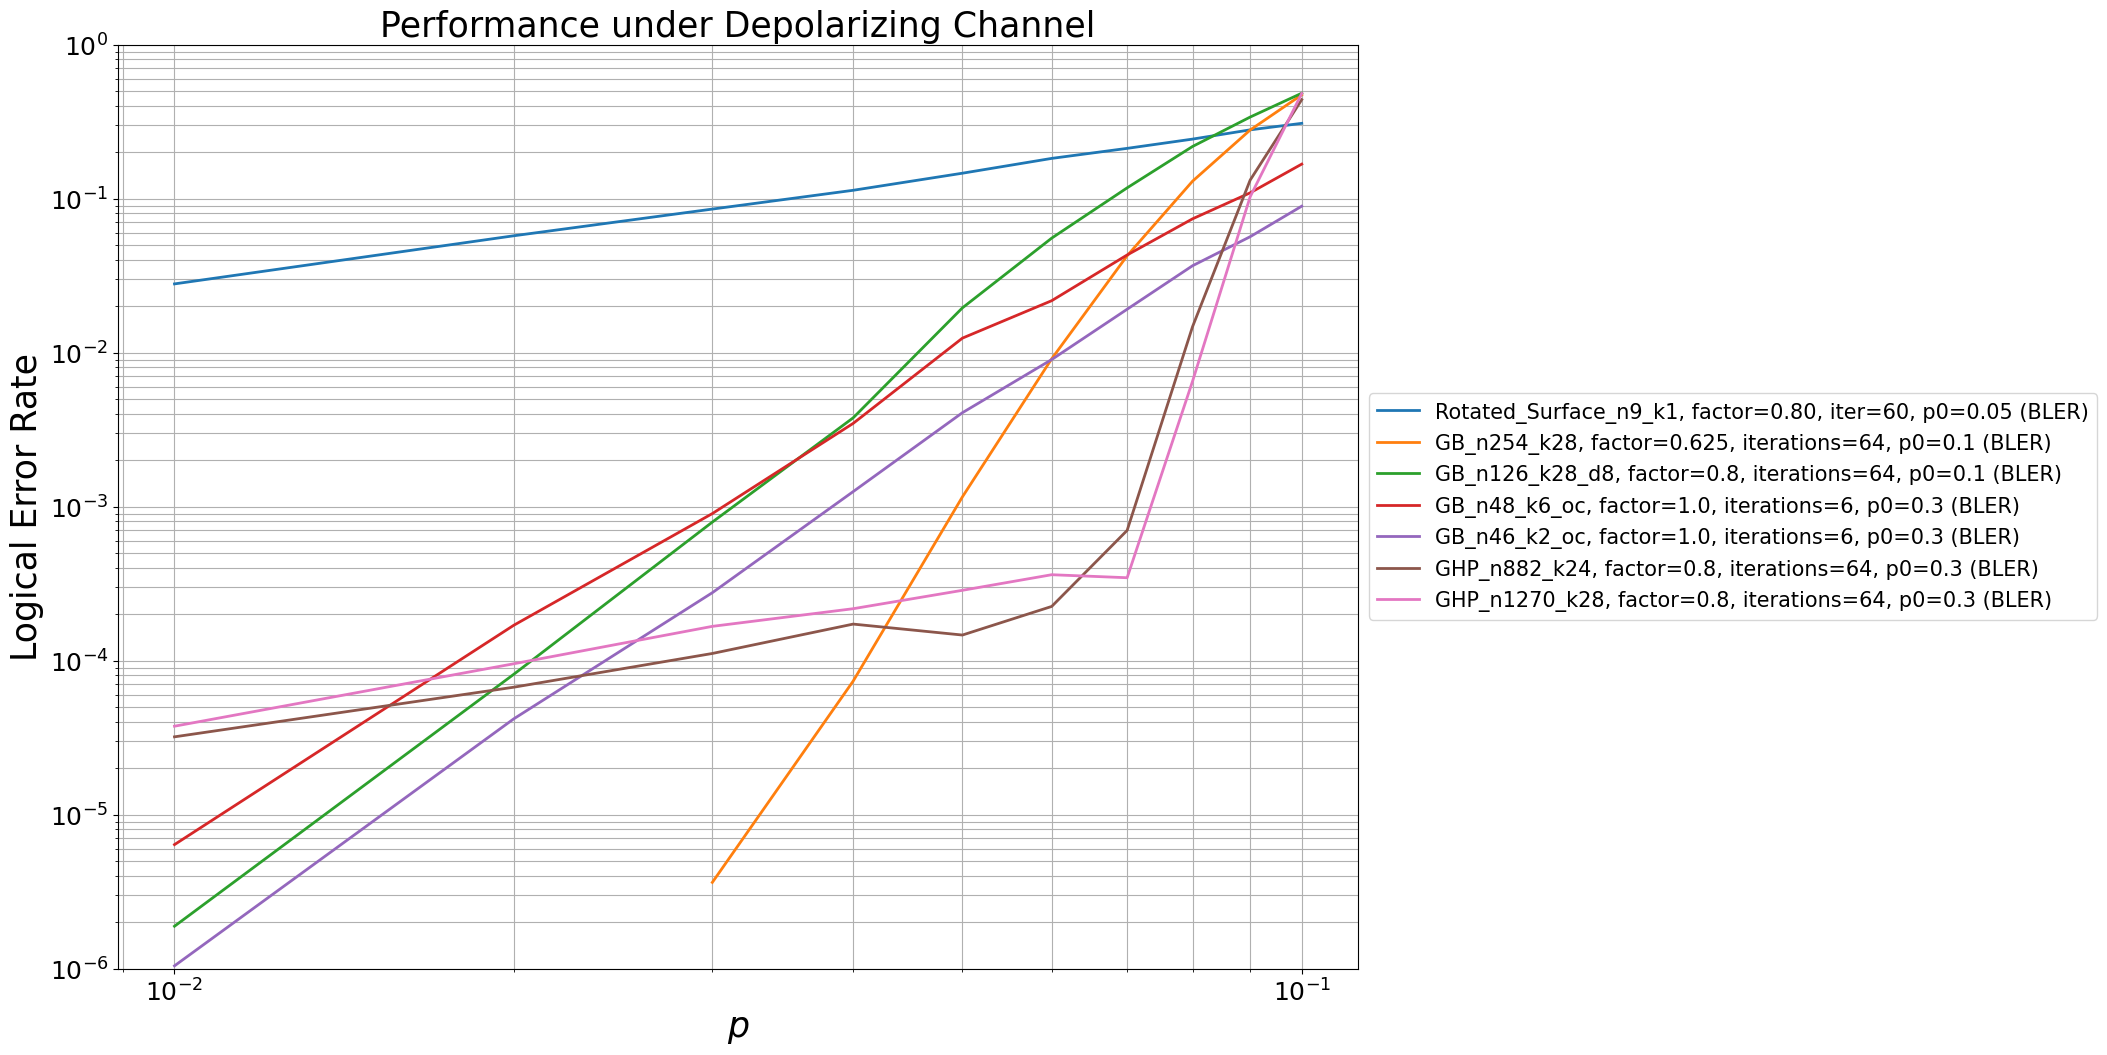

In [9]:
fig, ax = plt.subplots(figsize=(16,12))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(f"Performance under Depolarizing Channel", fontsize=25)
plt.grid(which="both")
plt.xlabel(r"$p$", fontsize=25)
plt.ylabel(r"Logical Error Rate", fontsize=25)
# A more flexible way of plotting the simulation results stored in ber_plot
for i in range(len(ber_plot._snrs)):
    if i % 2 == 0: # even i: flagged error rates
        continue   # odd  i: block error rates
    plt.loglog(ber_plot._snrs[i], ber_plot._bers[i], label=ber_plot._legends[i], linewidth=2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
plt.ylim([1e-6, 1])